In [3]:
## Simple trend-following strategy switching between the S&P 500 and Gold
### The strategy:
### (1) Ensure the trend of 52-week SPX high is up
### (2) Ensure the trend of the SPX is up
### (3) If (1) or (2) is in an uptrend, calculate the rate of change of $SPY and $GLD for the last 150 days
### (4) Buy the strongest of SPX or Gold, or the one that qualifies (>0). If (3) < 0, then stay in cash
### CAGR: +11.2%  maxDD -20.5% 

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
import yfinance as yf
import requests
import pandas_datareader as pdr

In [107]:
tickers = ['SPY', 'GC=F']

df = yf.download(tickers, period='max', interval="1d")
df = df['Adj Close']
df.rename(columns={'SPY':'SPX', 'GC=F': 'Gold'}, inplace=True) 
df.dropna(inplace=True)
df.head()

[*********************100%***********************]  2 of 2 completed


,Gold,SPX
Date,,
2000-08-30,273.899994,98.630516
2000-08-31,278.299988,99.942612
2000-09-01,277.000000,100.045120
2000-09-05,275.799988,99.245529
2000-09-06,274.200012,98.118027


In [108]:
# 52 Week High Indicator
### SHOULD BE NYSE new 52w high vs 52w low indicator
df['52w_high'] = 0
for i in range(df.shape[0]):
    if i < 252:
        df.iloc[i,2]  = df.SPX[1:i,].max()
    else:
        df.iloc[i,2] = df.SPX[i-252:i,].max()
df.dropna(inplace=True)
df.iloc[-365:-355,1:] #ensuring not lookahead bias

,SPX,52w_high
Date,,
2021-12-08,458.656433,458.861572
2021-12-09,455.559784,458.861572
2021-12-10,459.848175,458.861572
2021-12-13,455.774719,459.848175
2021-12-14,452.638947,459.848175
2021-12-15,459.711456,459.848175
2021-12-16,455.657471,459.848175
2021-12-17,450.807953,459.848175
2021-12-20,446.014343,459.848175


<AxesSubplot:xlabel='Date'>

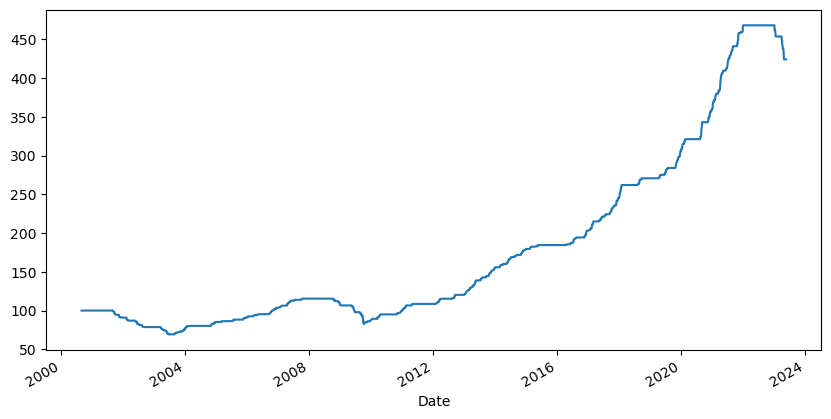

In [109]:
df.iloc[:,2].plot(figsize=(10,5))

In [110]:
df['52w_10_day_MA'] = df["52w_high"].rolling(window=10).mean().shift() #shift to ensure no lookahead bias
df['52w_100_day_MA'] = df["52w_high"].rolling(window=100).mean().shift()

In [111]:
df['SPX_10_day_MA'] = df.SPX.rolling(window=10).mean().shift()
df['SPX_100_day_MA'] = df.SPX.rolling(window=100).mean().shift()

In [112]:
df.dropna(inplace=True)
df.head()

,Gold,SPX,52w_high,52w_10_day_MA,52w_100_day_MA,SPX_10_day_MA,SPX_100_day_MA
Date,,,,,,,
2001-01-29,262.799988,90.114899,100.04512,100.04512,100.044095,88.811969,90.937832
2001-01-30,265.500000,90.906517,100.04512,100.04512,100.045120,89.115434,90.838529
2001-01-31,265.600006,90.391975,100.04512,100.04512,100.045120,89.442399,90.755139
2001-02-01,268.500000,90.992294,100.04512,100.04512,100.045120,89.677710,90.677879
2001-02-02,267.100006,88.927414,100.04512,100.04512,100.045120,89.885435,90.598216


<AxesSubplot:xlabel='Date'>

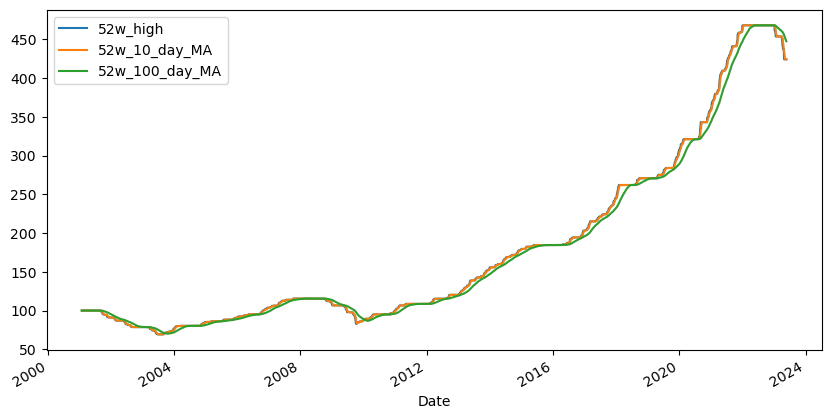

In [113]:
df.loc[:,["52w_high","52w_10_day_MA","52w_100_day_MA"]].plot(figsize=(10,5))

<AxesSubplot:xlabel='Date'>

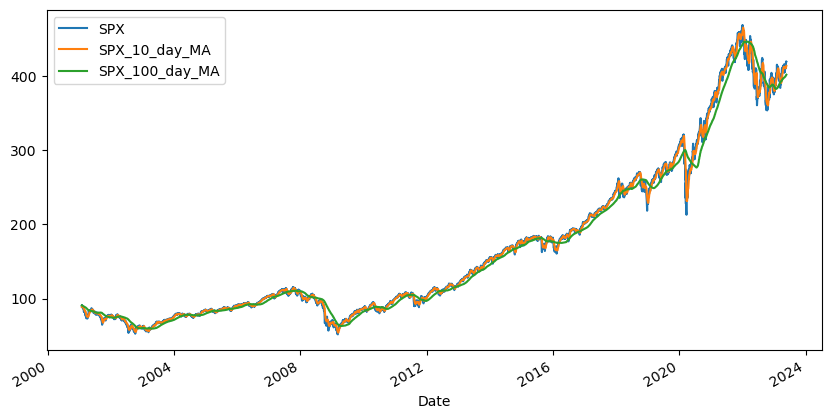

In [114]:
df.loc[:,["SPX","SPX_10_day_MA","SPX_100_day_MA"]].plot(figsize=(10,5))

In [115]:
# Check that the trend of the 52w High and SPY is up
df['SPX_Signal'] = np.where(df['SPX_10_day_MA'] > df['SPX_100_day_MA'], 1, 0)
df['52w_Signal'] = np.where(df['52w_10_day_MA'] > df['52w_100_day_MA'], 1, 0)

# If S&P 500 or 52 week high is in an uptrend, overall trend indicator positive
df['Trend_signal'] = np.where(np.logical_or(df['SPX_Signal'] == 1, df['52w_Signal'] == 1), 1, 0)
df.dropna(inplace=True)
df.head()

,Gold,SPX,52w_high,52w_10_day_MA,52w_100_day_MA,SPX_10_day_MA,SPX_100_day_MA,SPX_Signal,52w_Signal,Trend_signal
Date,,,,,,,,,,
2001-01-29,262.799988,90.114899,100.04512,100.04512,100.044095,88.811969,90.937832,0,1,1
2001-01-30,265.500000,90.906517,100.04512,100.04512,100.045120,89.115434,90.838529,0,0,0
2001-01-31,265.600006,90.391975,100.04512,100.04512,100.045120,89.442399,90.755139,0,0,0
2001-02-01,268.500000,90.992294,100.04512,100.04512,100.045120,89.677710,90.677879,0,0,0
2001-02-02,267.100006,88.927414,100.04512,100.04512,100.045120,89.885435,90.598216,0,0,0


In [116]:
df.drop(columns=["52w_high","52w_10_day_MA","52w_100_day_MA","SPX_10_day_MA","SPX_100_day_MA"], inplace=True)

# Calc. 150 day return - overfitted #50,100,150,200
df['SPX_ROC_Ind'] = round(df.SPX.pct_change(periods=150).shift() * df['Trend_signal'],4)
df['Gold_ROC_Ind'] = round(df.Gold.pct_change(periods=150).shift() * df['Trend_signal'],4)
df['Gold'] = df['Gold'].pct_change()
df['SPX'] = df['SPX'].pct_change()
df.dropna(inplace=True)
df

,Gold,SPX,SPX_Signal,52w_Signal,Trend_signal,SPX_ROC_Ind,Gold_ROC_Ind
Date,,,,,,,
2001-09-04,-0.010204,-0.006395,0,0,0,-0.0000,0.0000
2001-09-05,0.001473,0.002468,0,0,0,-0.0000,0.0000
2001-09-06,0.003676,-0.025769,0,0,0,-0.0000,0.0000
2001-09-07,0.000366,-0.018507,0,0,0,-0.0000,0.0000
2001-09-10,-0.005492,0.012233,0,0,0,-0.0000,0.0000
...,...,...,...,...,...,...,...
2023-05-16,-0.014668,-0.006683,1,0,1,0.1480,0.1867
2023-05-17,-0.003872,0.012139,1,0,1,0.1491,0.1926
2023-05-18,-0.012218,0.009633,1,0,1,0.1705,0.1799


In [117]:
# Daily rebalance strategy
df['Entry'] = ""
df['Strategy_DailyRebal'] = 0
df.head()

,Gold,SPX,SPX_Signal,52w_Signal,Trend_signal,SPX_ROC_Ind,Gold_ROC_Ind,Entry,Strategy_DailyRebal
Date,,,,,,,,,
2001-09-04,-0.010204,-0.006395,0,0,0,-0.0,0.0,,0
2001-09-05,0.001473,0.002468,0,0,0,-0.0,0.0,,0
2001-09-06,0.003676,-0.025769,0,0,0,-0.0,0.0,,0
2001-09-07,0.000366,-0.018507,0,0,0,-0.0,0.0,,0
2001-09-10,-0.005492,0.012233,0,0,0,-0.0,0.0,,0


In [118]:
# Assuming purchase as the close
for i in range(df.shape[0]-1):
    if df['SPX_ROC_Ind'][i] > 0 and df["Gold_ROC_Ind"][i] <= 0:
        df.iloc[i+1,-2] = "SPX"
        df.iloc[i+1,-1] = df['SPX'][i+1]
    elif df['SPX_ROC_Ind'][i] <= 0 and df["Gold_ROC_Ind"][i] > 0:
        df.iloc[i+1,-2] = "Gold"
        df.iloc[i+1,-1] = df['Gold'][i+1]
    elif df['SPX_ROC_Ind'][i] > 0 and df["Gold_ROC_Ind"][i] > 0:
        if df['SPX_ROC_Ind'][i] > df["Gold_ROC_Ind"][i]:
            df.iloc[i+1,-2] = "SPX"
            df.iloc[i+1,-1] = df['SPX'][i+1]
        else:
            df.iloc[i+1,-2] = "Gold"
            df.iloc[i+1,-1] = df['Gold'][i+1]
    else:
        df.iloc[i+1,-1] = 0
    
#     Adding transaction costs
    if df.iloc[i,-2] != df.iloc[i-1,-2]:
        df.iloc[i,-1] = df.iloc[i,-1]-0.0005
    

df

,Gold,SPX,SPX_Signal,52w_Signal,Trend_signal,SPX_ROC_Ind,Gold_ROC_Ind,Entry,Strategy_DailyRebal
Date,,,,,,,,,
2001-09-04,-0.010204,-0.006395,0,0,0,-0.0000,0.0000,,0.000000
2001-09-05,0.001473,0.002468,0,0,0,-0.0000,0.0000,,0.000000
2001-09-06,0.003676,-0.025769,0,0,0,-0.0000,0.0000,,0.000000
2001-09-07,0.000366,-0.018507,0,0,0,-0.0000,0.0000,,0.000000
2001-09-10,-0.005492,0.012233,0,0,0,-0.0000,0.0000,,0.000000
...,...,...,...,...,...,...,...,...,...
2023-05-16,-0.014668,-0.006683,1,0,1,0.1480,0.1867,Gold,-0.014668
2023-05-17,-0.003872,0.012139,1,0,1,0.1491,0.1926,Gold,-0.003872
2023-05-18,-0.012218,0.009633,1,0,1,0.1705,0.1799,Gold,-0.012218


In [119]:
# Daily Rebalance
dailyStrategy = (1+df['Strategy_DailyRebal']).cumprod()
SPX = (1+df['SPX']).cumprod()
print(dailyStrategy, SPX)

Date
2001-09-04    1.000000
2001-09-05    1.000000
2001-09-06    1.000000
2001-09-07    1.000000
2001-09-10    1.000000
                ...   
2023-05-16    8.302820
2023-05-17    8.270667
2023-05-18    8.169617
2023-05-19    8.262316
2023-05-22    8.274849
Name: Strategy_DailyRebal, Length: 5445, dtype: float64 Date
2001-09-04    0.993605
2001-09-05    0.996058
2001-09-06    0.970390
2001-09-07    0.952431
2001-09-10    0.964083
                ...   
2023-05-16    5.417835
2023-05-17    5.483602
2023-05-18    5.536427
2023-05-19    5.528371
2023-05-22    5.536757
Name: SPX, Length: 5445, dtype: float64


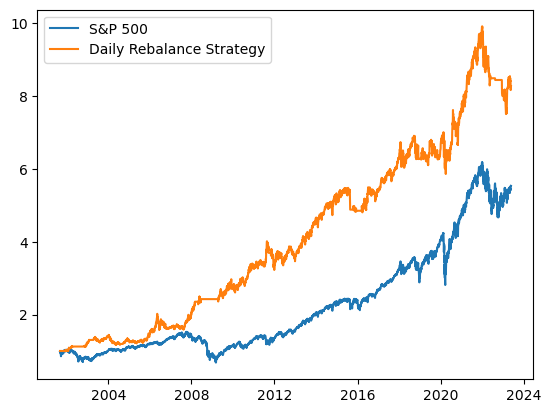

In [120]:
plt.plot(df.index, SPX, label='S&P 500')
plt.plot(df.index, dailyStrategy, label='Daily Rebalance Strategy')
plt.legend(loc=0)

Max Drawdown:-24.26%
Max Drawdown Duration: 476 days
Date of Max DrawDown: 2023-02-24 00:00:00


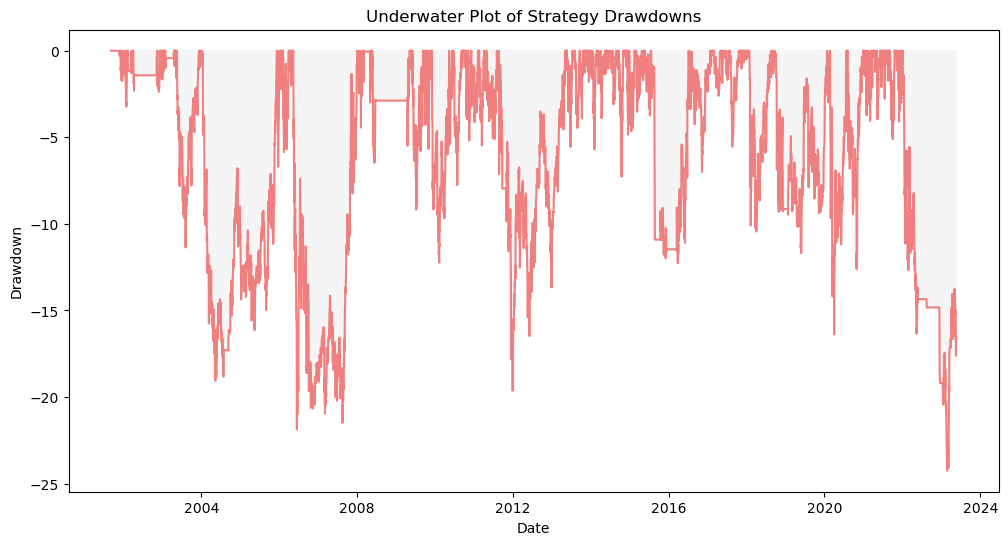

In [121]:
# DD and Return Stats
def calculate_MaxDD(dataframe):
    """
    Calculates the drawdown statistics for an asset or strategy
    """
    cumreturn = dataframe
    highwatermark = np.zeros(cumreturn.shape)
    drawdown = np.zeros(cumreturn.shape)
    drawdownduration = np.zeros(cumreturn.shape)

    for t in np.arange(1, cumreturn.shape[0]):
        highwatermark[t] = np.maximum(highwatermark[t - 1], cumreturn[t])
        drawdown[t] = (cumreturn[t] - highwatermark[t])/ (highwatermark[t])
        if drawdown[t] == 0:
            drawdownduration[t] = 0
        else:
            drawdownduration[t] = drawdownduration[t - 1] + 1

    maxDD, i = np.min(drawdown), np.argmin(drawdown)
    maxDDD = np.max(drawdownduration)
    DD_Date = cumreturn.index[i]
    return f"Max Drawdown:{round(maxDD*100,2)}%\nMax Drawdown Duration: {int(maxDDD)} days\nDate of Max DrawDown: {DD_Date}"

    
def underwater_plot(dataframe):
    """
    Plots the drawdown profile of an asset from the asset price dataframe
    """
    cum_max = dataframe.cummax()
    drawdowns = (dataframe - cum_max) / cum_max
    drawdowns = round(drawdowns*100,2)
    
    plt.figure(figsize=(12, 6))
    plt.plot(drawdowns.index, drawdowns, color="lightcoral")
    plt.fill_between(drawdowns.index, drawdowns, 0, where=drawdowns < 0, interpolate=True, color="whitesmoke")
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.title("Underwater Plot of Strategy Drawdowns")
    plt.show()
    
    
print(calculate_MaxDD(dailyStrategy))
underwater_plot(dailyStrategy)

In [122]:
# Reformat to monthly data
df_m = df.copy()
df_m = df.loc[df.groupby(df.index.to_period('M')).apply(lambda x: x.index.max())]
df_m

,Gold,SPX,SPX_Signal,52w_Signal,Trend_signal,SPX_ROC_Ind,Gold_ROC_Ind,Entry,Strategy_DailyRebal
Date,,,,,,,,,
2001-09-28,0.002400,0.021218,0,0,0,-0.0000,0.0000,,0.000000
2001-10-31,-0.003920,-0.003391,0,0,0,-0.0000,0.0000,,0.000000
2001-11-30,0.001463,-0.007138,1,0,1,-0.0713,0.0329,Gold,0.001463
2001-12-31,0.007957,-0.014655,1,0,1,-0.0928,0.0106,Gold,0.007957
2002-01-31,0.000710,0.011710,1,0,1,-0.0708,0.0349,Gold,0.000710
...,...,...,...,...,...,...,...,...,...
2023-01-31,0.003432,0.014703,1,0,1,0.0359,0.0528,SPX,0.014703
2023-02-28,0.006549,-0.003696,1,0,1,0.0155,0.0521,Gold,0.006549
2023-03-31,-0.005706,0.014095,1,0,1,-0.0118,0.1330,Gold,-0.005706


In [123]:
# Monthly date index
eom = df_m.index
eom.freq=None
eom = eom.tolist()
eom = eom[:-1] # Omitting the last date as it's usually incorrect
df_index = df_m.index.tolist()
print(eom[0] == df_index[0])

True


In [124]:
# Assuming purchase as the close
df["Strategy_mthRebal"] = 0

for i in eom:
    if df['Entry'][i] == 'SPX':
        df["Strategy_mthRebal"][i:] = df.SPX[i:]
        df["Strategy_mthRebal"][i] = df.SPX[i] - 0.0005 # adding transaction costs
    elif df['Entry'][i] == 'Gold':
        df["Strategy_mthRebal"][i:] = df.Gold[i:]
        df["Strategy_mthRebal"][i] = df.Gold[i] - 0.0005
    else:
        df["Strategy_mthRebal"][i:] = 0     

df

C:\Users\44791\AppData\Local\Temp\ipykernel_29048\3894070759.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Strategy_mthRebal"][i:] = 0
C:\Users\44791\AppData\Local\Temp\ipykernel_29048\3894070759.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Strategy_mthRebal"][i:] = df.Gold[i:]


,Gold,SPX,SPX_Signal,52w_Signal,Trend_signal,SPX_ROC_Ind,Gold_ROC_Ind,Entry,Strategy_DailyRebal,Strategy_mthRebal
Date,,,,,,,,,,
2001-09-04,-0.010204,-0.006395,0,0,0,-0.0000,0.0000,,0.000000,0.000000
2001-09-05,0.001473,0.002468,0,0,0,-0.0000,0.0000,,0.000000,0.000000
2001-09-06,0.003676,-0.025769,0,0,0,-0.0000,0.0000,,0.000000,0.000000
2001-09-07,0.000366,-0.018507,0,0,0,-0.0000,0.0000,,0.000000,0.000000
2001-09-10,-0.005492,0.012233,0,0,0,-0.0000,0.0000,,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2023-05-16,-0.014668,-0.006683,1,0,1,0.1480,0.1867,Gold,-0.014668,-0.014668
2023-05-17,-0.003872,0.012139,1,0,1,0.1491,0.1926,Gold,-0.003872,-0.003872
2023-05-18,-0.012218,0.009633,1,0,1,0.1705,0.1799,Gold,-0.012218,-0.012218


In [125]:
# Monthly Rebalance
mthStrategy = (1+df['Strategy_mthRebal']).cumprod()
SPX = (1+df['SPX']).cumprod()
print(mthStrategy, SPX)

Date
2001-09-04    1.000000
2001-09-05    1.000000
2001-09-06    1.000000
2001-09-07    1.000000
2001-09-10    1.000000
                ...   
2023-05-16    9.483390
2023-05-17    9.446666
2023-05-18    9.331248
2023-05-19    9.437127
2023-05-22    9.419004
Name: Strategy_mthRebal, Length: 5445, dtype: float64 Date
2001-09-04    0.993605
2001-09-05    0.996058
2001-09-06    0.970390
2001-09-07    0.952431
2001-09-10    0.964083
                ...   
2023-05-16    5.417835
2023-05-17    5.483602
2023-05-18    5.536427
2023-05-19    5.528371
2023-05-22    5.536757
Name: SPX, Length: 5445, dtype: float64


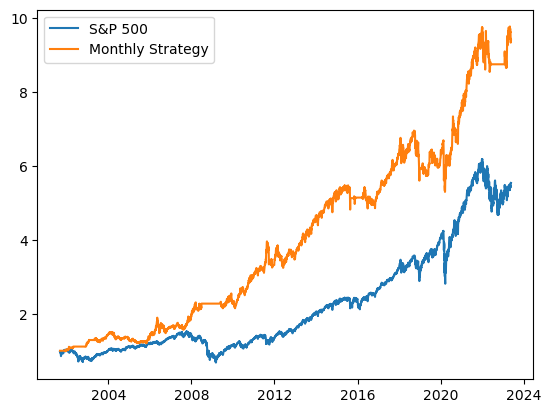

In [126]:
plt.plot(df.index, SPX, label='S&P 500')
plt.plot(df.index, mthStrategy, label='Monthly Strategy')
plt.legend(loc=0)

Max Drawdown:-23.83%
Max Drawdown Duration: 513 days
Date of Max DrawDown: 2020-03-18 00:00:00


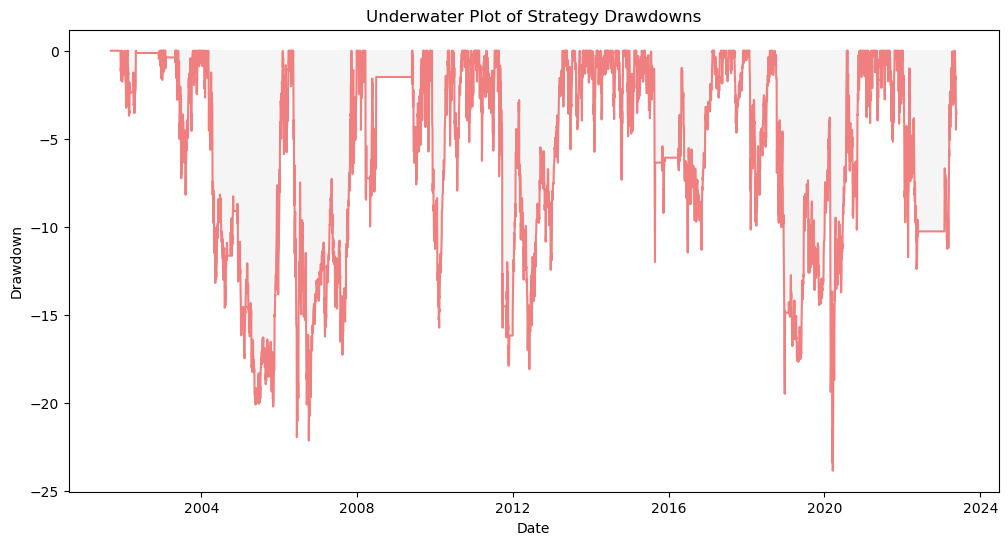

In [127]:
print(calculate_MaxDD(mthStrategy))
underwater_plot(mthStrategy)

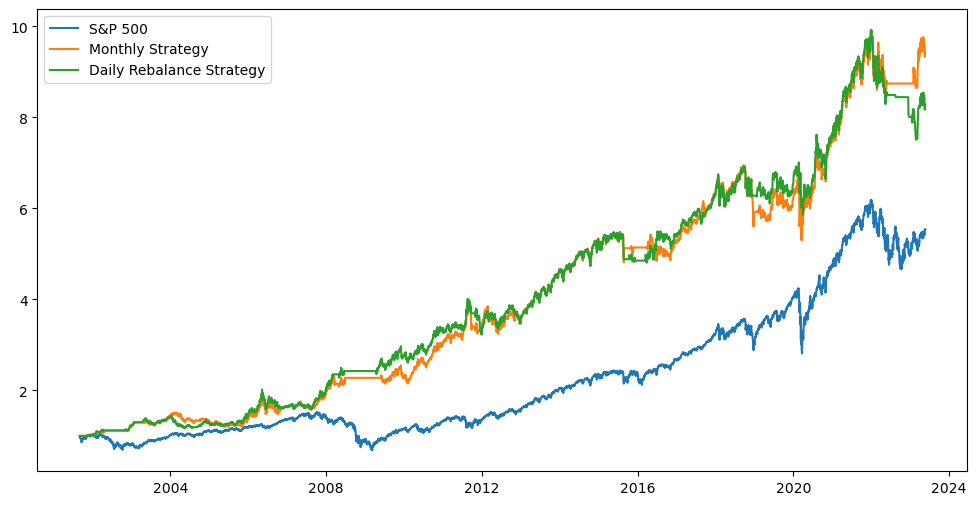

In [131]:
plt.figure(figsize=(12,6))
plt.plot(df.index, SPX, label='S&P 500')
plt.plot(df.index, mthStrategy, label='Monthly Strategy')
plt.plot(df.index, dailyStrategy, label='Daily Rebalance Strategy')
plt.legend(loc=0)

In [149]:
# Return Statistics
excess_mthly = df['Strategy_mthRebal'] - 0.04/252
mthly_sharpe = np.sqrt(252) * np.mean(excess_mthly) / np.std(excess_mthly)

excess_daily = df['Strategy_DailyRebal'] - 0.04/252
daily_sharpe = np.sqrt(252) * np.mean(excess_daily) / np.std(excess_daily)
print(f"Sharpe Ratio:\nDaily Rebalance: {daily_sharpe}\nMonthly Rebalance: {mthly_sharpe}")

Sharpe Ratio:
Daily Rebalance: 0.4893956065245748
Monthly Rebalance: 0.521680254005696
